# Try to find good pairs of images for comparison

In [1]:
import math
import os
import matplotlib.pyplot as plt
import imageio
import pandas as pd
import numpy as np
%matplotlib inline

In [2]:
data_path = '.'

## Load the data

In [3]:
images = pd.read_csv(os.path.join(data_path, 'osinac_metadata_orientation.csv.gz'))

Make sure that timestamps are correctly formatted for slicing and dicing

In [4]:
images.start_time = pd.to_datetime(images.start_time)
images.stop_time = pd.to_datetime(images.stop_time)

In [5]:
len(images)

10352

# Produce some pairs

First try taking a few images pre-perihelion and comparing to after - this is not the only relevant set of comparisons, but let's give it a try:

In [6]:
t_perihelion = pd.Timestamp('2015-08-13T02:03:00Z').to_datetime64()

In [7]:
pre = images[images.start_time<t_perihelion]
post = images[images.start_time>=t_perihelion]

In [8]:
len(pre), len(post)

(3997, 6355)

Define a simple function to check for possible pairs:
- check that the distance between the boresight intercepts is < half the first image width
- put some constraints on the phase angle and and field of view etc.

This is where "the magic" happens, so this should be tweaked as needed to get optimal pairs

In [119]:
def best_match(df1, df2, idx1):
    matches = []
    distance = []
    if idx1 not in df1.index:
        print('no matching index in df1')
        return None, None
    img = df1.loc[idx1]
    for idx, match in df2.iterrows():
        
        dist = math.sqrt( (match.surf_int_x-img.surf_int_x)**2 + (match.surf_int_y-img.surf_int_y)**2 + (match.surf_int_z-img.surf_int_z)**2 )
        phase_diff = abs(img.phase_angle-match.phase_angle)
        alt_diff = abs(img.sc_altitude-match.sc_altitude)
        
        if (dist < img.half_width/2.) and (alt_diff<5.) and (phase_diff<25.):
            distance.append(dist)
            matches.append(idx)
            
    if len(matches)>0:
        return matches[distance.index(min(distance))], min(distance)
    else:
        return None, None

This now returns the index of the best match and the distance between the intercept point on the comet

In [120]:
idx, dist = best_match(pre, post, 200)
idx, dist

(6373, 0.2671890716328046)

Now let's look at these two images - we will use the browse image link to display the jpeg image streamed from the archive. We also want to use the calculated comet North vector in the DataFrame to either display with an arrow this direction, or rotate the images to match.

In [121]:
def rotation_angle(vec1, vec2):
    """Returns the anticlockwise rotation angle between vec1 and vec2"""
    unit_1 = vec1 / np.linalg.norm(vec1)
    unit_2 = vec2 / np.linalg.norm(vec2)
    dot = np.dot(unit_1, unit_2)
    angle = np.rad2deg(np.arccos(dot))
    if np.cross(vec2, vec1) > 0:
        angle = 360. - angle
    return angle

In [149]:
def show_pair(df1, df2, idx1, idx2=None, rotate=False, arrow_length=200):
    """Given two DataFrames (df1, df2) and the index into the first (idx1) calculate
    the best match in the second. If both idx1 and idx2 are given these are simply
    used.
    
    If rotate=False both images are displayed with an arrow pointing to comet north.
    If rotate=True, the second image is rotated to match the orientation of the first"""

    if idx2 is None:
        idx2, dist = best_match(df1, df2, idx1)
        if idx2 is None:
            print('No match found')
            return

    if rotate:
        from PIL import Image
        from urllib.request import urlopen

        # calculate the angle between the two North vectors
        vec1 = np.array([df1.loc[idx1].vec1, df1.loc[idx1].vec2])
        vec2 = np.array([df2.loc[idx2].vec1, df2.loc[idx2].vec2])
        angle = rotation_angle(vec1, vec2)

        fig, axs = plt.subplots(1,2,figsize=(12,6))
        img1 = Image.open(urlopen(df1.loc[idx1].browse_url))
        axs[0].imshow(np.asarray(img1), cmap='gray', aspect='equal')

        img2 = Image.open(urlopen(df2.loc[idx2].browse_url))
        img2 = img2.rotate(angle, expand=False, fillcolor='white')
        axs[1].imshow(np.asarray(img2), cmap='gray', aspect='equal')

    else:
        fig, axs = plt.subplots(1,2,figsize=(12,6))
        img1 = imageio.imread(df1.loc[idx1].browse_url)
        axs[0].imshow(img1, cmap='gray', aspect='equal')
        axs[0].arrow(1700, 250, arrow_length * df1.loc[idx1].vec1, arrow_length * df1.loc[idx1].vec2, color=[1,1,0], head_width=50)

        img2 = imageio.imread(df2.loc[idx2].browse_url)
        axs[1].imshow(img2, cmap='gray', aspect='equal')
        axs[1].arrow(1700, 250, arrow_length * df2.loc[idx2].vec1, arrow_length * df2.loc[idx2].vec2, color=[1,1,0], head_width=50)

    axs[0].set_axis_off()
    axs[0].title.set_text(df1.loc[idx1].prod_id.strip('.FIT'))
    axs[1].set_axis_off()
    axs[1].title.set_text(df2.loc[idx2].prod_id.strip('.FIT'))



Use the first image in the pre-herihelion dataset, find the best match and display both with an arrow showing the orientation of comet North

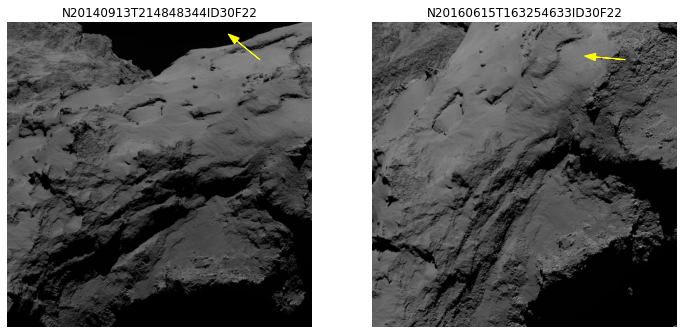

In [150]:
show_pair(pre, post, 0, rotate=False)

Do the same, but rotate the second image to match (for now it is rotated in the same image frame and cropped to match)

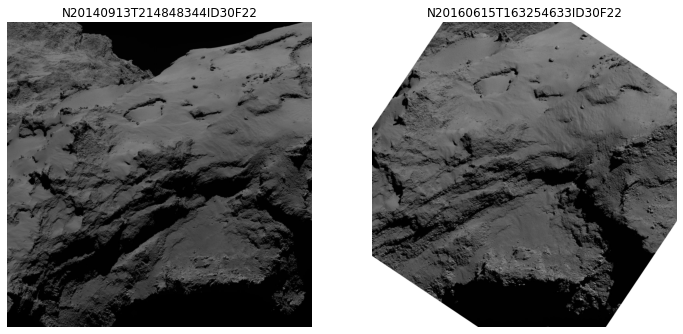

In [151]:
show_pair(pre, post, 0, rotate=True)

Check another example:

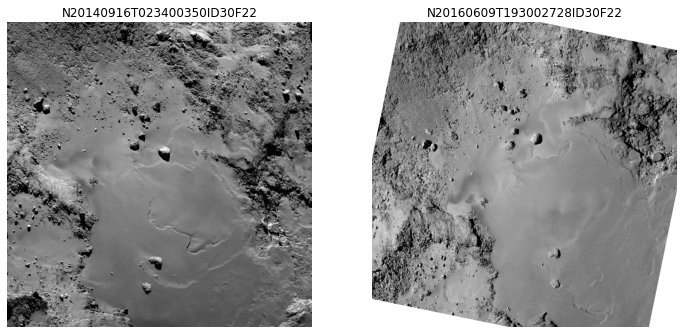

In [152]:
show_pair(pre, post, 2, rotate=True)

Now try rotating the second image to match the first. Find the angle between the two vectors and rotate the second image.

Loop through all pre-perihelion images and find the best post-perihelion image, if any.

Note that this is not at all optimised, and running all the combinations is going to be slooow. 

In [77]:
match_pre = []
match_post = []

In [78]:
for idx1 in pre.index:
    idx2, dist = best_match(pre, post, idx1)
    if idx2 is None:
        continue
    else:
        match_pre.append(idx1)
        match_post.append(idx2)

In [79]:
len(match_pre)

3408

In [102]:
len(pre)

3997

So we have >3k matches according to the criteria in the best_match function. Many of these will not be useful and so human inspection will be needed to quickly discard some. Now we can loop through this list and accept or discard each match.

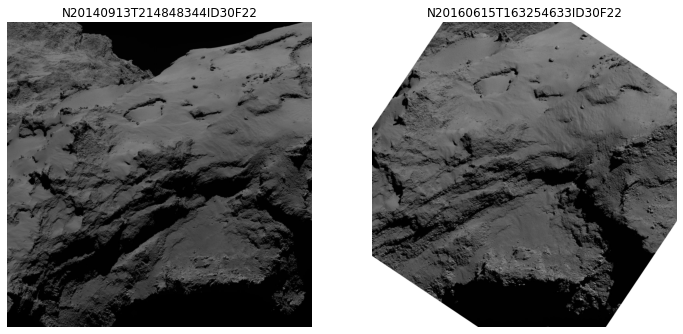

In [153]:
idx = 0
show_pair(pre, post, match_pre[idx], match_post[idx], rotate=True)

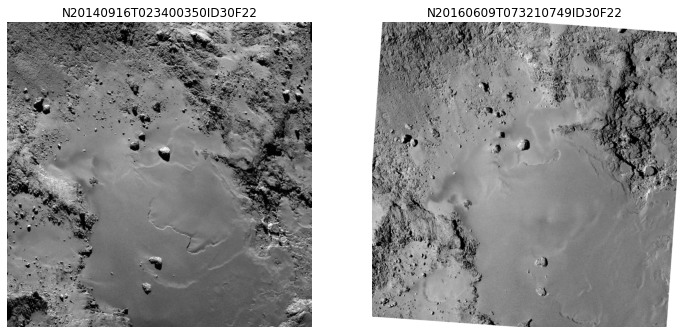

In [154]:
idx = 2
show_pair(pre, post, match_pre[idx], match_post[idx], rotate=True)

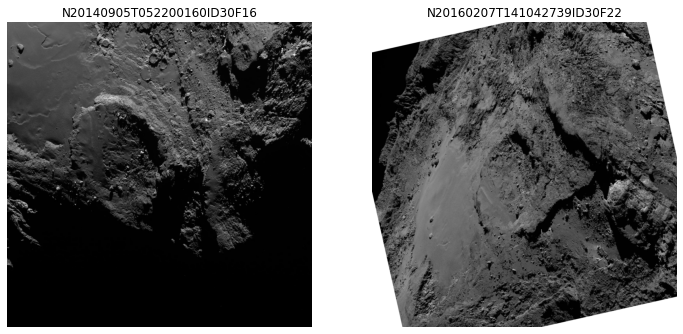

In [155]:
idx = 49
show_pair(pre, post, match_pre[idx], match_post[idx], rotate=True)

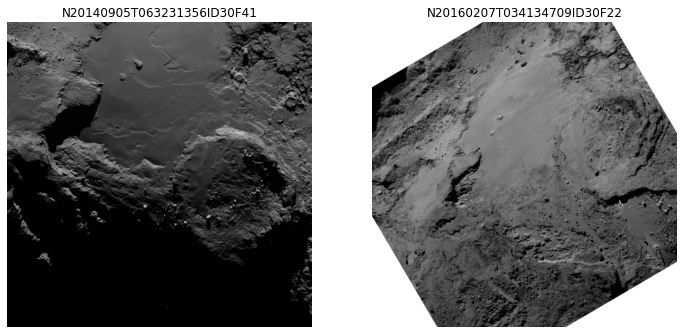

In [156]:
idx = 79
show_pair(pre, post, match_pre[idx], match_post[idx], rotate=True)

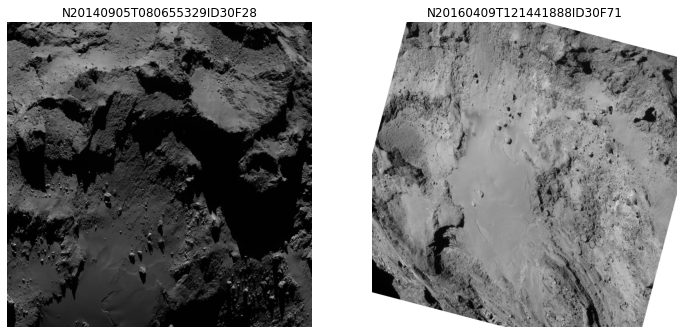

In [160]:
idx = 120
show_pair(pre, post, match_pre[idx], match_post[idx], rotate=True)

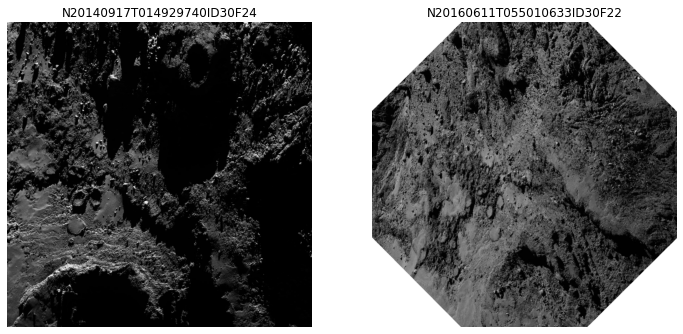

In [161]:
idx = 1000
show_pair(pre, post, match_pre[idx], match_post[idx], rotate=True)